In [1]:
%matplotlib inline

import numpy as np 
import scipy
import matplotlib.pyplot as plt

# add the gridding path 
# import sys
# sys.path.append("/home/ian/Research/Disks/MillionPoints/million-points-of-light")
# sys.path.append("/Users/ianczekala/Documents/ALMA/million-points-of-light")

# import gridding

import theano
import theano.tensor as tt
from theano.tensor import fft

import pymc3 as pm

# convert from arcseconds to radians
arcsec = np.pi / (180.0 * 3600) # [radians]  = 1/206265 radian/arcsec

In [2]:
def sky_plane(alpha, dec, a=1, delta_alpha=1.0*arcsec, delta_delta=1.0*arcsec, sigma_alpha=1.0*arcsec,
              sigma_delta=1.0*arcsec, Omega=0.0):
    '''
    alpha: ra (in radians)
    delta: dec (in radians)
    a : amplitude
    delta_alpha : offset (in radians)
    delta_dec : offset (in radians)
    sigma_alpha : width (in radians)
    sigma_dec : width (in radians)
    Omega : position angle of ascending node (in degrees east of north)
    '''

    return a * np.exp(-( (alpha - delta_alpha)**2/(2 * sigma_alpha**2) + \
                        (dec - delta_delta)**2/(2 * sigma_delta**2)))


def fourier_plane(u, v, a=1, delta_alpha=1.0*arcsec, delta_delta=1.0*arcsec, sigma_alpha=1.0*arcsec,
              sigma_delta=1.0*arcsec, Omega=0.0):
    '''
    Calculate the Fourier transform of the Gaussian. Assumes u, v in kλ.
    '''

    # convert back to lambda
    u = u * 1e3
    v = v * 1e3

    return 2 * np.pi * a * sigma_alpha * sigma_delta * np.exp(- 2 * np.pi**2 * \
                (sigma_alpha**2 * u**2 + sigma_delta**2 * v**2) - 2 * np.pi * 1.0j * \
                                                    (delta_alpha * u + delta_delta * v))


# the gradients
def dV_ddelta_alpha(u, v, a=1, delta_alpha=1.0*arcsec, delta_delta=1.0*arcsec, sigma_alpha=1.0*arcsec,
              sigma_delta=1.0*arcsec, Omega=0.0):
    
    
    return -2 * np.pi * 1j * u * fourier_plane(u*1e-3, v*1e-3, a, delta_alpha, delta_delta, sigma_alpha,
              sigma_delta, Omega)


def dV_ddelta_delta(u, v, a=1, delta_alpha=1.0*arcsec, delta_delta=1.0*arcsec, sigma_alpha=1.0*arcsec,
              sigma_delta=1.0*arcsec, Omega=0.0):
    
    
    return -2 * np.pi * 1j * v * fourier_plane(u*1e-3, v*1e-3, a, delta_alpha, delta_delta, sigma_alpha,
              sigma_delta, Omega)


In [3]:
def fftspace(width, N):
    '''Oftentimes it is necessary to get a symmetric coordinate array that spans ``N``
     elements from `-width` to `+width`, but makes sure that the middle point lands
     on ``0``. The indices go from ``0`` to ``N -1.``
     `linspace` returns  the end points inclusive, wheras we want to leave out the
     right endpoint, because we are sampling the function in a cyclic manner.'''

    assert N % 2 == 0, "N must be even."

    dx = width * 2.0 / N
    xx = np.empty(N, np.float)
    for i in range(N):
        xx[i] = -width + i * dx
    
    return xx

In [4]:
# Let's plot this up and see what it looks like 

N_alpha = 128
N_dec = 128
img_radius = 15.0 * arcsec


# full span of the image
ra = fftspace(img_radius, N_alpha) # [arcsec]
dec = fftspace(img_radius, N_dec) # [arcsec]

In [5]:
# calculate the maximum u and v points that our image grid can sample 
dRA = (2 * img_radius) / N_alpha # radians
max_baseline = 1 / (2 * dRA) * 1e-3 # kilolambda, nyquist rate
print(max_baseline) # kilolambda

440.03158666047227


In [6]:
# load the fake data

N_vis = 100 # number of data points 

data_points = np.load("data_points.npy")
print(data_points.shape)
u_data, v_data = data_points.T

data_real = np.load("data_real.npy")
data_imag = np.load("data_imag.npy")
print(data_real.shape, data_imag.shape)

noise = np.load("noise.npy")
print(noise.shape)

(100, 2)
(100,) (100,)
(100,)


In [7]:
# create fixed quantities that we can pre-calculate in numpy before stuffing into the Theano part 

# the image plane grid (fixed throughout the problem)
XX, YY = np.meshgrid(np.fft.fftshift(ra), np.fft.fftshift(dec))

# the image-plane taper (fixed throughout problem)
corrfun_mat = np.load("corrfun.npy")

# the u and v coordinates of the RFFT output (also fixed throughout problem)
u_coords = np.fft.rfftfreq(N_alpha, d=(2 * img_radius)/N_alpha) * 1e-3  # convert to [kλ]
v_coords = np.fft.fftfreq(N_dec, d=(2 * img_radius)/N_dec) * 1e-3  # convert to [kλ]

# load the C_real and C_imag matrices (stored as dense arrays in numpy save files)
# these are scipy csc sparse matrices that will be stuffed into Theano objects
C_real = scipy.sparse.csc_matrix(np.load("C_real.npy"))
C_imag = scipy.sparse.csc_matrix(np.load("C_imag.npy"))

In [8]:
C_real

<100x8320 sparse matrix of type '<class 'numpy.float64'>'
	with 3543 stored elements in Compressed Sparse Column format>

In [9]:
C_imag

<100x8320 sparse matrix of type '<class 'numpy.float64'>'
	with 3543 stored elements in Compressed Sparse Column format>

# Sampling in PyMC3 

In [21]:
with pm.Model() as model:

    # the image-plane grid over which the sky model will be evaluated
    # NOTE that these must be `fftshifted` already.
    # add an extra dimension for the later packing into the rfft
    alpha = theano.shared(XX[np.newaxis,:])
    dalpha = abs(alpha[0,0,1] - alpha[0,0,0])
    delta = theano.shared(YY[np.newaxis,:])
    ddelta = abs(delta[0,1,0] - delta[0,0,0])
    
    # Define the PyMC3 model parameters, which are just for the image plane model
    a = pm.Uniform("a", lower=0.0, upper=10.0)
    delta_alpha = pm.Uniform("deltaAlpha", lower=-1*arcsec, upper=2*arcsec)
    delta_delta = pm.Uniform("deltaDelta", lower=-1*arcsec, upper=2*arcsec)
    sigma_alpha = pm.Uniform("sigmaAlpha", lower=0.5*arcsec, upper=1.5*arcsec)
    sigma_delta = pm.Uniform("sigmaDelta", lower=0.5*arcsec, upper=1.5*arcsec)
    
    # Calculate the sky-plane model
    I = a * tt.exp(-(alpha - delta_alpha)**2/(2 * sigma_alpha**2) - (delta - delta_delta)**2/(2 * sigma_delta**2))
    # since the input coordinates were already shifted, then this is too
    # I shape should be (1, N_dec, N_alpha)

    # taper the image with the gridding correction function
    # this should broadcast OK, since the trailing image dimensions match
    corrfun = theano.shared(corrfun_mat)
    I_tapered = I * corrfun

    # use the FFT to transform the image sky model to the Fourier plane
    # output from the RFFT is (1, N_delta, N_alpha//2 + 1, 2)
    rfft = dalpha * ddelta * fft.rfft(I_tapered, norm=None)  

    # Store the interpolation matrices as theano shared variables, make sure it's sparse
    C_real_sparse = theano.sparse.CSC(C_real.data, C_real.indices, C_real.indptr, C_real.shape)
    C_imag_sparse = theano.sparse.CSC(C_imag.data, C_imag.indices, C_imag.indptr, C_imag.shape)

    # flatten the RFFT output appropriately for the interpolation, taking the real and imag parts separately
    vis_real = rfft[0, :, :, 0].flatten() # real values 
    vis_imag = rfft[0, :, :, 1].flatten() # imaginary values

    # interpolate the RFFT to the baselines by a sparse matrix multiply
    interp_real = theano.sparse.dot(C_real_sparse, vis_real[:, None])[:, 0]
    interp_imag = theano.sparse.dot(C_imag_sparse, vis_imag[:, None])[:, 0]
    
    # condition on the real and imaginary observations
    pm.Normal("obsReal", mu=interp_real, sd=noise, observed=data_real)
    pm.Normal("obsImag", mu=interp_imag, sd=noise, observed=data_imag)

In [22]:
model.basic_RVs

[a_interval__,
 deltaAlpha_interval__,
 deltaDelta_interval__,
 sigmaAlpha_interval__,
 sigmaDelta_interval__,
 obsReal,
 obsImag]

In [23]:
model.unobserved_RVs

[a_interval__,
 deltaAlpha_interval__,
 deltaDelta_interval__,
 sigmaAlpha_interval__,
 sigmaDelta_interval__,
 a,
 deltaAlpha,
 deltaDelta,
 sigmaAlpha,
 sigmaDelta]

In [24]:
model.free_RVs

[a_interval__,
 deltaAlpha_interval__,
 deltaDelta_interval__,
 sigmaAlpha_interval__,
 sigmaDelta_interval__]

In [25]:
with model:
    s = pm.Metropolis(vars=model.free_RVs)
    trace = pm.sample(100, tune=100, step=s, cores=1)

Only 100 samples in chain.
Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [sigmaDelta]
>Metropolis: [sigmaAlpha]
>Metropolis: [deltaDelta]
>Metropolis: [deltaAlpha]
>Metropolis: [a]
100%|██████████| 200/200 [00:01<00:00, 109.33it/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The number of effective samples is smaller than 10% for some parameters.


In [26]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
a,1.187338,4.937688e-02,4.887271e-03,1.087009,1.281632,10.857464,1.005174
deltaAlpha,0.000005,2.056691e-08,2.049703e-09,0.000005,0.000005,1.412041,2.172106
deltaDelta,0.000005,2.534174e-08,2.530757e-09,0.000005,0.000005,1.101423,3.935868
sigmaAlpha,0.000004,2.070673e-07,2.054973e-08,0.000004,0.000005,5.065734,1.131315
sigmaDelta,0.000005,1.210584e-07,1.186326e-08,0.000004,0.000005,13.878302,1.011762


In [27]:
with model:
    trace = pm.sample(draws=1000, tune=1000, chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigmaDelta, sigmaAlpha, deltaDelta, deltaAlpha, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [01:41<00:00, 33.97draws/s]


In [28]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
a,1.000033,2.686923e-03,7.526518e-05,0.994999,1.005488,1219.979867,1.000182
deltaAlpha,0.000005,1.146231e-08,2.901972e-10,0.000005,0.000005,1912.370385,0.999552
deltaDelta,0.000005,1.122060e-08,2.601706e-10,0.000005,0.000005,1836.272464,0.999501
sigmaAlpha,0.000005,1.399659e-08,3.501981e-10,0.000005,0.000005,1586.454826,0.999877
sigmaDelta,0.000005,1.131656e-08,2.774020e-10,0.000005,0.000005,1729.435962,0.999588


/home/ian/.build/anaconda/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f179b700400>,
      dtype=object)

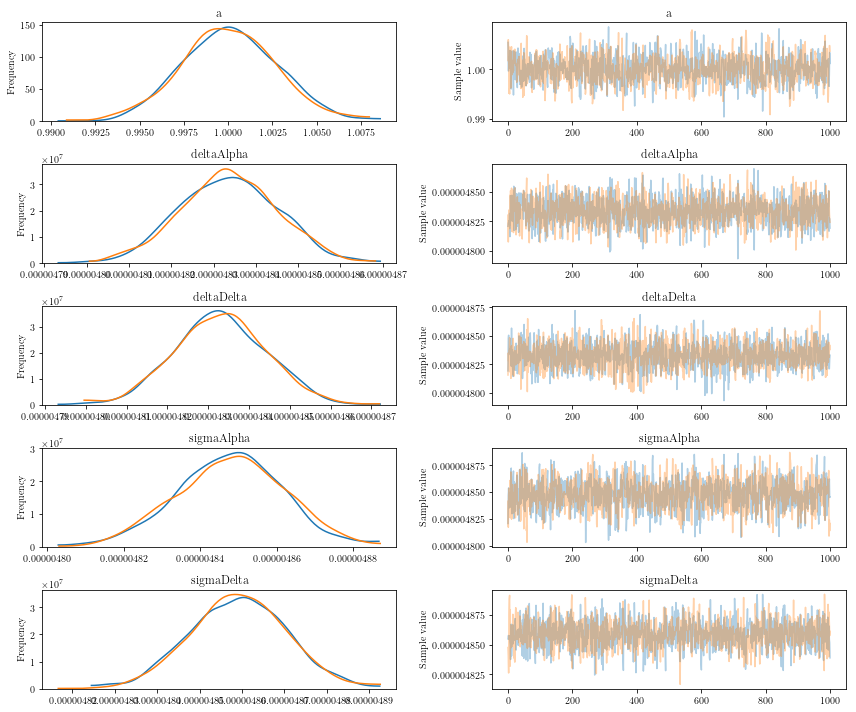

In [29]:
pm.traceplot(trace)